In [1]:
# TODO: Hide me!
%matplotlib inline

Notes: 

- This notebook is *pre-executed* (see [here](http://nbsphinx.readthedocs.io/en/0.2.13/never-execute.html)); this way, we don't necessarily have to distribute large binary output files to re-build the docs. **However**, we may wish to package those separately, so that developers and community members can contribute new tutorial notebooks. I've globally set notebooks to never be run, although this could be over-ridden per notebook.

# Working with xarray and pandas

In this tutorial, we'll introduce a tool called [xarray](http://xarray.pydata.org/en/stable/), which provides some specialized data structures for working with multi-dimensional arrays and their labels and metadata. This document walks through a simple analysis, introducing key features of xarray as they are encountered.


## xarray Overview

### Model Output

Most the output from climate, weather, and chemical transport models like GEOS-Chem is usually generated in the form of dense, multi-dimensional arrays with some sort of corresponding, underlying grid system. It usually comes with a rich set of metadata describing its contents: some standardized description of the fields and variables in each array, additional information such as physical units, metrics such as whether or not time averaging or some other reduction was applied, and history about how the data has been modified over different processing steps. The metadata usually extends to the grid system, too, providing details such as timestamps and latitude/longitude coordinates for the grid components.

Oftentimes when we work with this type of data, we ignore the metadata and focus only on the raw numerical data - the arrays. But, the metadata provides a powerful, flexible, *semantic* way to reference and pull apart this raw numerical data. 

### xarray

Enter xarray. Fundamentally, xarray implements a standardized, abstract data model used to contain scientific datasets. This data model fuse metadata and labels to the raw numerical data inside a given dataset, which allows for a higher-level way to interface with your data.

<div class="alert alert-info">

**Note:**

The [Common Data Model](http://www.unidata.ucar.edu/software/thredds/current/netcdf-java/CDM) adopted by xarray (and best exemplified by a `Dataset` object) is really just an in-memory mock-up of a NetCDF file - a portable, commonly used file format for sharing geophysical model output and other data in the geosciences.

</div>

Borrowing from the xarray documentation, suppose you have temperature and precipitation output from a weather model. That data may contain arrays with the following dimensional structure:

<img src="http://xarray.pydata.org/en/stable/_images/dataset-diagram.png", width=50%>

Notice that we've aligned the common dimensions for each of our data arrays. This sort of alignment operation is extremely important, because it allows us to delegate away the task of figure out what indices of each of our arrays correspond with one another. With machinery in place to do this alignment automatically, we can vectorize our calculations using these arrays, which produces simpler, easier-to-read/write code, and code which executes much faster (since numerical libraries are usually written in highly-performant C or Fortran). 

Additionally, tightly linking data to metadata in this way allows us to use our labeled dimensions to index into our datasets; this allows us to write expressive (declarative) code which describes *what* parts of the data set we wish to use, and delegates to some standard library the task of *how* those parts should be extracted. 


## Worked example: Hourly $\mathrm{PM}_{2.5}$

In this example, we will derive a field from a set of GEOS-Chem output and use xarray's machinery to code a somewhat complicated analysis - an analysis of the hourly-resolved diurnal cycle in $\mathrm{PM}_{2.5}$ at each grid point in our dataset.


### Data Ingestion

Like most analysis tasks, we start by reading in GEOS-Chem output data. xarray was originally designed to work with NetCDF output. However, it provides plumbing for users to extend its capabilities and build interfaces to other datasets. For instance, it can natively read in GRIB-format meteorology data through the [PyNIO](https://www.pyngl.ucar.edu/Nio.shtml) package developed at NCAR, and can read remote datasets accessed through [OPeNDAP](http://www.opendap.org/). 

Here, we use [xbpch](http://xbpch.readthedocs.io/en/latest/) to read in binary punch output from GEOS-Chem. xbpch simply takes care of parsing the binary output file on disk and manipulating it to be satisfy the particulars of how xarray expects its data.

We begin by constructing the paths to 31 daily ND49 files, each which contain 24 timesteps (hourly) of a subset of GEOS-Chem output fields.

In [2]:
import glob
import xbpch

from os.path import join

ROOT = "/Users/daniel/workspace/bpch/test_data/"
fns = glob.glob(join(ROOT, "ND49*.bpch"))[:31]
print(fns[:2])

['/Users/daniel/workspace/bpch/test_data/ND49_20060101_ref_e2006_m2010.bpch', '/Users/daniel/workspace/bpch/test_data/ND49_20060102_ref_e2006_m2010.bpch']


/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


Reading in this data with xbpch is straightforward.

<div class="alert alert-info">

**Note**: For more information on how to read in single or multi-file datasets with xbpch, see [here](http://xbpch.readthedocs.io/en/latest/usage.html#reading-output).

</div>

In [3]:
nd49_data = xbpch.open_mfbpchdataset(
    fns, 
    diaginfo_file="/Users/daniel/Desktop/sample_nd49/diaginfo.dat",
    tracerinfo_file="/Users/daniel/Desktop/sample_nd49/tracerinfo.dat",
    dask=True, memmap=True,
)
print(nd49_data)

<xarray.Dataset>
Dimensions:          (lat: 91, lev: 47, lon: 144, nv: 2, time: 744)
Coordinates:
  * lev              (lev) float64 0.9925 0.9775 0.9624 0.9473 0.9322 0.9171 ...
  * lon              (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 ...
  * lat              (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 ...
  * nv               (nv) int64 0 1
  * time             (time) datetime64[ns] 2006-01-01T01:00:00 ...
Data variables:
    IJ_AVG_S_NO      (time, lon, lat) float32 0.00116601 0.0011599 ...
    time_bnds        (time, nv) datetime64[ns] 2006-01-01T01:00:00 ...
    IJ_AVG_S_O3      (time, lon, lat) float32 9.25816 9.25042 9.1552 8.43072 ...
    IJ_AVG_S_SO4     (time, lon, lat) float32 0.141706 0.14142 0.145294 ...
    IJ_AVG_S_NH4     (time, lon, lat) float32 0.0116908 0.0116658 0.0114135 ...
    IJ_AVG_S_NIT     (time, lon, lat) float32 9.99837e-22 9.99897e-22 ...
    IJ_AVG_S_BCPI    (time, lon, lat) float32 0.00246206 0.00245698 ...
    IJ_AVG_S_OC

It takes a few seconds to loop over all 31 files and construct the dataset in memory, but this penalty only has to be paid once. Notice that when we print the object we loaded, we get a rich representation of our dataset, showing all of the coordinates, the available data variables, and attributes saved wwith the dataset.

This object, **nd49_data**, is an [`xarray.Dataset`](http://xarray.pydata.org/en/stable/data-structures.html#dataset), and is functionally a represenation of a netCDF file in memory. We can either perform operations directly on this `Dataset`, or we can pull apart one of its components, also known as a [`DataArray`](http://xarray.pydata.org/en/stable/data-structures.html#dataarray).

In [4]:
sala = nd49_data['IJ_AVG_S_SALA']
print(sala)

<xarray.DataArray 'IJ_AVG_S_SALA' (time: 744, lon: 144, lat: 91)>
dask.array<concatenate, shape=(744, 144, 91), dtype=float32, chunksize=(1, 144, 91)>
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 -165.0 ...
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 ...
  * time     (time) datetime64[ns] 2006-01-01T01:00:00 2006-01-01T02:00:00 ...
Attributes:
    number:          42
    category:        IJ-AVG-$
    molwt:           0.0314
    C:               1
    name:            SALA
    chemical:        True
    tracer:          42
    full_name:       SALA tracer
    hydrocarbon:     False
    original_shape:  (144, 91)
    origin:          (1, 1, 1)
    scale_factor:    1000000000.0
    units:           ppbv


Note that when we pull out **sala**, we retain the coordinates for the data. Usually when we print out a `DataArray` in this way, we get a sneak preview into the values in the dataset. However, xbpch has special functionality which *defers* loading/processing the data until it's necessary, so all we get to see is the line `dask.array<concatenate, shape=(744, 144, 91), dtype=float32, chunksize=(1, 144, 91)>`, which is just telling us that xarray is keeping track of all the operations necessary to return the data we requested and will do so when and only when it must.

Alternatively, we can access *IJ_AVG_S_SALA* field using attribute notation:

In [5]:
sala = nd49_data.IJ_AVG_S_SALA

Depending on how you're accessing the data (directly versus programatically), using the dictionary-style access may be preferable to the attribute-style. But they do the same thing under the hood.

### Subset USA

Our sample data is on a 2x2.5 degree grid, which - in other applications - can be very memory intensive. However, we only want to perform our analysis on cells near the United States. In general, we usually want to subset our data before we do analysis on it, just so that we can save time and memory.

#### Looping

Traditionally, to do this, we'd first compute how many cells in each coordinate direction will fit into our data, set up an array, and copy data over into it. This can be done with a bunch of loops.

In [6]:
import numpy as np

sala_data = sala.data.compute()
lons, lats = sala.lon.values, sala.lat.values

lon_lo, lon_hi = -120, -65
lat_lo, lat_hi = 24, 50

# Helper function to find start/end indices in label array
def find_start_end(vals, lo, hi):
    start, end = None, None

    for i, val in enumerate(vals):
        if (val >= lo) and start is None:
            start = i
        elif (val >= hi) and end is None:
            end = i+1
    
    if start is None:
        start = 0
    if end is None:
        end = -1
        
    return start, end
lon_start, lon_end = find_start_end(lons, lon_lo, lon_hi)
lat_start, lat_end = find_start_end(lats, lat_lo, lat_hi)
    
# Try to figure out dimensions of **sala_data**
nt, nlon, nlat = sala_data.shape
usa_data = np.zeros((nt, lon_end - lon_start, lat_end - lat_start))
for i, ilon in enumerate(range(lon_start, lon_end)):
    for j, jlon in enumerate(range(lat_start, lat_end)):
        usa_data[:, i, j] = sala_data[:, ilon, jlon]
print(usa_data.shape)

(744, 23, 14)


This... works. But it's very brittle, it's a lot of code, and it's generally a mess.

#### NumPy Vectorization

A slightly better way is to *vectorize* our calculation using NumPy's fancy indexing rules. This is similar to how you might do things in MATLAB or R; we create an **index array** of boolean values that tell us which values on each dimension/axis we want to retain.

In [7]:
def make_mask(vals, lo, hi):
    mask = np.zeros_like(vals, dtype=bool)
    for i, val in enumerate(vals):
        if lo <= val <= hi:
            mask[i] = True
    return mask

lon_mask = make_mask(lons, lon_lo, lon_hi)
lat_mask = make_mask(lats, lat_lo, lat_hi)

# Sequentially apply the 1D array masks
usa_data = sala_data[:, lon_mask, :]
usa_data = usa_data[:, :, lat_mask]

This could be marginally improved in two ways:

1. We can construct the vector masks in place a bit more efficiently
2. We can 'broadcast' the vector masks to multi dimensions and apply them simultaneously

Both these options reduce the amount of code we write, but tend to obfuscate what we're doing a bit more. For very large arrays, they may be *far* more efficient than this method. But the point here is that if we were to stay in NumPy world, we could accomplish the subsetting task much more easily.

#### xarray selection

xarray trivializes these sorts of [selection and indexing operations](http://xarray.pydata.org/en/stable/indexing.html). Although we can use integer indices to slice our data just as with NumPy, what xarray lets us do is operate on the *labels* corresponding to each dimension.

To do this, we construct a **slice** representing the interval we wish to subset:

$$ \mathbf{S} = [\mathrm{low}, \mathrm{hi}]$$

Behind the scenes, xarray computes the union of $\mathbf{S}$ with the set defining the coordinates in one of our dimensions. But it also takes care of all the indexing associated with these so we don't have to worry about it.

In [8]:
usa_data = sala.sel(lon=slice(lon_lo, lon_hi), 
                    lat=slice(lat_lo, lat_hi))
print(usa_data)

<xarray.DataArray 'IJ_AVG_S_SALA' (time: 744, lon: 23, lat: 14)>
dask.array<getitem, shape=(744, 23, 14), dtype=float32, chunksize=(1, 23, 14)>
Coordinates:
  * lon      (lon) float64 -120.0 -117.5 -115.0 -112.5 -110.0 -107.5 -105.0 ...
  * lat      (lat) float64 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 42.0 ...
  * time     (time) datetime64[ns] 2006-01-01T01:00:00 2006-01-01T02:00:00 ...
Attributes:
    number:          42
    category:        IJ-AVG-$
    molwt:           0.0314
    C:               1
    name:            SALA
    chemical:        True
    tracer:          42
    full_name:       SALA tracer
    hydrocarbon:     False
    original_shape:  (144, 91)
    origin:          (1, 1, 1)
    scale_factor:    1000000000.0
    units:           ppbv


Alternatively, we could've selected values based on the integer indices, too, by using the `.isel()` method.

In [9]:
usa_data = sala.isel(lon=slice(lon_start, lon_end),
                     lat=slice(lat_start, lat_end))
usa_data

<xarray.DataArray 'IJ_AVG_S_SALA' (time: 744, lon: 23, lat: 14)>
dask.array<getitem, shape=(744, 23, 14), dtype=float32, chunksize=(1, 23, 14)>
Coordinates:
  * lon      (lon) float64 -120.0 -117.5 -115.0 -112.5 -110.0 -107.5 -105.0 ...
  * lat      (lat) float64 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 42.0 ...
  * time     (time) datetime64[ns] 2006-01-01T01:00:00 2006-01-01T02:00:00 ...
Attributes:
    number:          42
    category:        IJ-AVG-$
    molwt:           0.0314
    C:               1
    name:            SALA
    chemical:        True
    tracer:          42
    full_name:       SALA tracer
    hydrocarbon:     False
    original_shape:  (144, 91)
    origin:          (1, 1, 1)
    scale_factor:    1000000000.0
    units:           ppbv

This is great for working with coordinates, but it extends to work with timestamps, too. Using `slice()`, you can pass strings containg a datetime-like format, and xarray will automatically convert them into appropriate timestamps and perform the same selection operations. In the dataset we are looking at here, we have hourly data between January 1, 2006 and February 1, 2006. We can select a specific day just by passing a strings in `YYYY/MM/DD` format:

In [10]:
usa_data.sel(time="2006/01/13")

<xarray.DataArray 'IJ_AVG_S_SALA' (time: 24, lon: 23, lat: 14)>
dask.array<getitem, shape=(24, 23, 14), dtype=float32, chunksize=(1, 23, 14)>
Coordinates:
  * lon      (lon) float64 -120.0 -117.5 -115.0 -112.5 -110.0 -107.5 -105.0 ...
  * lat      (lat) float64 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 42.0 ...
  * time     (time) datetime64[ns] 2006-01-13 2006-01-13T01:00:00 ...
Attributes:
    number:          42
    category:        IJ-AVG-$
    molwt:           0.0314
    C:               1
    name:            SALA
    chemical:        True
    tracer:          42
    full_name:       SALA tracer
    hydrocarbon:     False
    original_shape:  (144, 91)
    origin:          (1, 1, 1)
    scale_factor:    1000000000.0
    units:           ppbv

We can also ask for all timesteps within a specific range:

In [11]:
usa_data.sel(time=slice("2006/01/12 08:00:00", "2006/01/15 15:00:00"))

<xarray.DataArray 'IJ_AVG_S_SALA' (time: 80, lon: 23, lat: 14)>
dask.array<getitem, shape=(80, 23, 14), dtype=float32, chunksize=(1, 23, 14)>
Coordinates:
  * lon      (lon) float64 -120.0 -117.5 -115.0 -112.5 -110.0 -107.5 -105.0 ...
  * lat      (lat) float64 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 42.0 ...
  * time     (time) datetime64[ns] 2006-01-12T08:00:00 2006-01-12T09:00:00 ...
Attributes:
    number:          42
    category:        IJ-AVG-$
    molwt:           0.0314
    C:               1
    name:            SALA
    chemical:        True
    tracer:          42
    full_name:       SALA tracer
    hydrocarbon:     False
    original_shape:  (144, 91)
    origin:          (1, 1, 1)
    scale_factor:    1000000000.0
    units:           ppbv

#### Calculate $\mathrm{PM}_{2.5}$

Because xarray objects are just wrappers around the `numpy.ndarray`, we can use them almost anywhere and in almost anyway we'd use arrays or scalars. This is useful, because we need to add a few fields together and re-scale them to estimate $\mathrm{PM}_{2.5}$ from our data.

Before we do this calculation, it's useful to do a little bit of setup. Again, we want to subset our data so we only have to deal with portions that'll be used in our calculation. In this case, we want to select a portion of the `DataArray`s contained in our data, so we'll make a list of those names and select them. Also, we're going to rename these fields; all of them have a group prefix **IJ\_AVG\_S\_** which we don't actually care about. To accomplish this, we'll use the `Dataset.rename()` function, which accepts a dictionary mapping some old field names to new ones.

In [12]:
mw_species = {
    'NH4': 18.,
    'NIT': 62.,
    'SO4': 96.,
    'BCPI': 12.,
    'OCPI': 12.,
    'BCPO': 12.,
    'OCPO': 12.,
    'DST1': 29.,
    'DST2': 29.,
    'SALA': 31.4,
}
pm_species = list(mw_species.keys())
pm_tracers = ['IJ_AVG_S_' + spec for spec in pm_species]

pm_subset = (
    nd49_data[pm_tracers]
    .copy()
    .rename({'IJ_AVG_S_' + spec: spec for spec in pm_species})
)

Now, we can follow the pseudocode from the [wiki page on $\mathrm{PM}_{2.5}$](http://wiki.seas.harvard.edu/geos-chem/index.php/Particulate_matter_in_GEOS-Chem):

```
PM25     = 1.33 (NH4 + NIT  + SO4) + BCPI + BCPO + 2.1 (OCPO + 1.16 OCPI) + 1.16 SOA  
         + DST1 + 0.38 DST2 + 1.86 SALA
```

Before we an perform this calculation, we need to convert our data from ppbv to $\mu$g m-3. In the following cell, we loop over the species we'll use in the PM calculation and modify their corresponding fields in place. Arithmetic like this doesn't preserve metadata, so we'll copy the saved attributes on each field, update the units to reflect the conversion, and the place them back with the data.

In [13]:
stp_p = 1013.25 # mb
stp_t = 298. # K

ppb_ugm3 = 100. * (stp_p/stp_t) * 1e-3 / 8.314

for spec in pm_species:
    attrs = pm_subset[spec].attrs
    pm_subset[spec] = pm_subset[spec]*ppb_ugm3*mw_species[spec]
    attrs['units'] = 'μg m-3'
    pm_subset[spec].attrs.update(attrs)

Now we can apply the formula and calculate $\mathrm{PM}_{2.5}$. Note that we don't have to do any sort of looping; xarray treats all of the data as arrays, and maps them on common coordinates/indices, allowing us to do large calculations at once.

In [14]:
pm_subset['PM25'] = (1.33 * (pm_subset['NH4'] + pm_subset['NIT'] + pm_subset['SO4'])
                     + (pm_subset['BCPO'] + pm_subset['BCPI']) 
                     + 2.1*(pm_subset['OCPO'] + 1.16*pm_subset['OCPI'])
                     + pm_subset['DST1'] + 0.38*pm_subset['DST2']
                     + 1.86*pm_subset['SALA'])
pm_subset['PM25'].attrs.update({
    'units': 'μg m-3', 'full_name': 'Total PM2.5', 'name': 'PM25'
})

pm25 = pm_subset['PM25']
print(pm25)

<xarray.DataArray 'PM25' (time: 744, lon: 144, lat: 91)>
dask.array<add, shape=(744, 144, 91), dtype=float32, chunksize=(1, 144, 91)>
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 -165.0 ...
  * lat      (lat) float64 -89.5 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 ...
  * time     (time) datetime64[ns] 2006-01-01T01:00:00 2006-01-01T02:00:00 ...
Attributes:
    full_name:  Total PM2.5
    name:       PM25
    units:      μg m-3


### Visualize Global Field

As a sanity check, let's check one timestep in our data to see that our data has sensible spatial characteristics and magnitudes.

xarray has built-in plotting functions which wrap matplotlib, the base plotting library in Python. It's very straightforward, then, to make a plot of this sort.

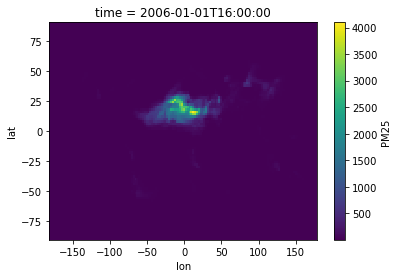

In [15]:
pm25.isel(time=15).plot.imshow(x='lon', y='lat')

This is mostly sensible; we have a lot of dust in sub-Saharan Africa which is a major regional hot-spot on our map. Note that our plotting wrapper automatically added a colorbar for us. While we can hand-construct any sort of plot we want, the defaults in xarray are often useful for exploratory data analysis. 

We can take this a step further by plotting our data on a geographic plot using cartopy. To do this, it's a little bit easier to set up our own `Figure` and `Axis` first and then tell xarray to plot on them.

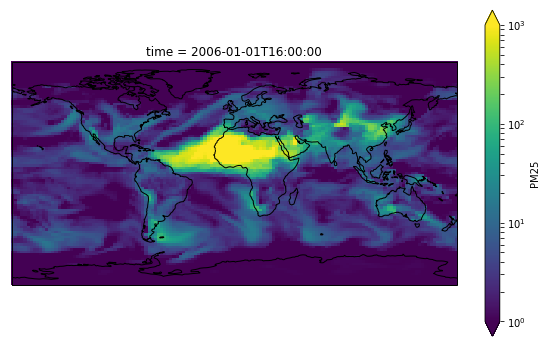

In [16]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(), aspect='auto')

pm25.isel(time=15).plot.imshow(x='lon', y='lat',
                               vmin=1, vmax=1000, norm=LogNorm(),
                               ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_aspect('equal', 'box-forced')

Here, we've done a few additional things:

1. We created a `Figure` and `Axis`, explicitly setting the figure size and instructing matplotlib to use one of cartopy's projections. We also pass it an **aspect** argument to force matplotlib to draw a map on whatever shape/size `Figure` we specified.

2. We specified parameters for our colormap, namely the minimum and maximum values and a **norm** object. By default, matplotlib uses linear  normalization; here, we ask it to use a lognornmal normalization so that we can tell the difference between dust and non-dust areas.

3. We ask the plotting function to transform our coordinate data using `ccrs.PlateCarree()`, a rectangluar latitude-longitude mapping.

4. Finally, we add coastlines to the plot and tweak its aspect ratio and sizing.

### Timeseries Analysis

Because xarray's heritage includes pandas in addition to NumPy, it has extensive support for idiomatic, declarative programming using grammars such as "split-apply-combine." We'll leverage this to group our data by hourly observations and compute means and standard deviation for each day of the week.

First, let's select a box of cells surrounding the United States, and access the $\mathrm{PM}_{2.5}$ data.

In [17]:
usa_pm25 = pm25.sel(lon=slice(lon_lo, lon_hi), 
                    lat=slice(lat_lo, lat_hi))
print(usa_pm25)

<xarray.DataArray 'PM25' (time: 744, lon: 23, lat: 14)>
dask.array<getitem, shape=(744, 23, 14), dtype=float32, chunksize=(1, 23, 14)>
Coordinates:
  * lon      (lon) float64 -120.0 -117.5 -115.0 -112.5 -110.0 -107.5 -105.0 ...
  * lat      (lat) float64 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 42.0 ...
  * time     (time) datetime64[ns] 2006-01-01T01:00:00 2006-01-01T02:00:00 ...
Attributes:
    full_name:  Total PM2.5
    name:       PM25
    units:      μg m-3


We'll drop into pandas to perform this analysis. 

<div class="alert alert-info">

**Note**: It *is* possible to perform the following analysis entirely within xarray, vectorizing across every cell in the lat-lon grid. However, this is a more advanced application with a few idiosyncrasies that can trip up people encountering this sort of workflow for the first time. Pandas is better suited for simple to medium-complexity versions of this sort of task.

</div>

#### Diurnal cycle

We've used this coding style before, but in the following analysis, we will *chain* our operations together. Method chaining is a coding style which greatly increases the transparency and readability of code; as long as users are familiar with the methods you're using (especially what they take as inputs and give as outputs), then it is essentially self-documenting.

In [18]:
df = usa_pm25.to_dataframe()

hourly_pm25 = (
    df.groupby([lambda x: x.hour, 'lon', 'lat'], level='time')
    .agg({'mean', 'std'})
    ['PM25']
    .add_prefix("PM25_")
    .to_xarray()
)
print(hourly_pm25)

<xarray.Dataset>
Dimensions:    (lat: 14, lon: 23, time: 24)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * lon        (lon) float64 -120.0 -117.5 -115.0 -112.5 -110.0 -107.5 ...
  * lat        (lat) float64 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 ...
Data variables:
    PM25_mean  (time, lon, lat) float32 14.9517 15.473 17.3169 18.267 ...
    PM25_std   (time, lon, lat) float32 16.8215 16.6204 20.1053 23.4273 ...


In this, we first groupby the hour at each timestep, longitude, and latitude. This produces a set of 24 x nlon x nlat groups. We then use the `.agg()` function to compute a few aggregations for each of these groups. In this case, we give it strings corresponding to **mean** and **std**, which will automatically call functions of the same name on our groups. We could also call an arbitrary function of our design - `.agg()` is a very flexible function for reducing the data in each group. 

Each aggregation will produce a sub-column corresponding to the data it was applied to, creating a *multi-index* of columsn. This is somewhat inconvenient, so we manipulate those dimensions by selecting the base column and just adding it as a prefix to the labels of the second column. We finish things off by converting back into xarray structures.

Let's look at this diurnal cycle in PM for a given grid cell in our dataset.

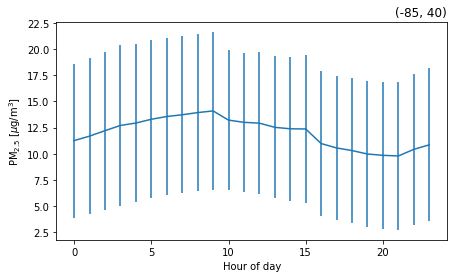

In [19]:
local = hourly_pm25.isel(lat=8, lon=14)

fig = plt.figure(figsize=(7, 4))
ax = fig.add_subplot(111) 

ax.errorbar(local.time, local.PM25_mean, yerr=local.PM25_std)
ax.set_xlabel("Hour of day")
ax.set_ylabel("PM$_{2.5}$ [$\mu$g/m$^3$]")
ax.set_title("({:g}, {:g})".format(float(local.lon), float(local.lat)), 
             loc='right')

#### Hourly anomalies

For this grid cell, we see something of a week diurnal trend, although there is huge variance associated with the hourly average for each day. To illustrate this, we'll aggregate once more by hour of the day, and compute anomalies from the mean for each hour so we can visualize a timeseries of hourly anomalies.

In [20]:
def _anom_from_mean(group):
    return group - group.mean()

hourly_anoms_pm25 = (
    df.groupby([lambda x: x.hour, 'lon', 'lat'], level='time')
    .apply(_anom_from_mean)
    .to_xarray()
)
print(hourly_anoms_pm25)

<xarray.Dataset>
Dimensions:  (lat: 14, lon: 23, time: 744)
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01T01:00:00 2006-01-01T02:00:00 ...
  * lon      (lon) float64 -120.0 -117.5 -115.0 -112.5 -110.0 -107.5 -105.0 ...
  * lat      (lat) float64 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 42.0 ...
Data variables:
    PM25     (time, lon, lat) float32 -10.7555 -11.9793 -13.5836 -15.1977 ...


Now we can plot this timeseries for the same location.

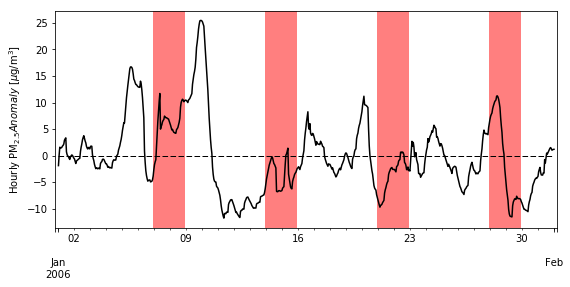

In [21]:
local = (
    hourly_anoms_pm25['PM25']
    .isel(lat=8, lon=14)
    .to_pandas()
)

fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(111) 

local.plot(ax=ax, color='k')
xlo, xhi = ax.get_xlim()
ax.hlines(0, xlo, xhi, linestyle='dashed', lw=1)
ax.set_xlim(xlo-5, xhi+5)
ax.set_xlabel("")
ax.set_ylabel("Hourly PM$_{2.5} Anomaly$ [$\mu$g/m$^3$]")

# Shade weekends
ylo, yhi = ax.get_ylim()
weekends = local.index.weekday_name.isin(['Saturday', 'Sunday'])
changes = np.diff(weekends)
times = local.loc[changes].index
begins, ends = times[1:-1:2], times[2::2]
for begin, end in zip(begins, ends):
    ax.axvspan(begin, end, color='red', alpha=0.5, lw=0)


A reasonable question might be to ask, "Does the diurnal cycle differ over weekends from the weekday?" On the prevous figure, I computed weekends and highlighted them in <span style="color: red">red</span> to help motivate this question. The details of this calculation are a bit cumbersome and it can probably be done much more efficiently, but it illustrates how vector calculations can be used to avoid looping/checking logic. It works essentially like this:

1. Using our vector of timestamps (the index of **local**), I grab the weekday name (as a string) of each value and check if each value is in a list that contains the names of weekend days. This yields a vector of True/False values.
2. I compute the "difference" of each pairwise value in this True/False vector. In Python, boolean values are "truthy", meaning that they correspond to 1/0. Thus, wherever the difference is non-zero, I can infer that I've detected the end of a weekday and beginning of weekend, or vice-versa. 
3. Using the inverse of this "truthiness", I can use this as a mask to access the values in my original dataset so that I can infer what specific timesteps they are. 
4. I split these timesteps into two lists, corresponding to a "beginning" and an "end" of the weekend.
5. Using zippered iteration, I iterate over pairs of beginning/end timesteps and shade my plot.

But again, there are many ways you could accomplish the same thing! This method works well and is extremely general.

#### Weekend/Weekday differences

To answer our question about the difference between weekend/weekday diurnal cycles, we can repeat our calculation. We'll use the same idea as before, but we'll assign two new column to the dataset to help simplify the "split-apply-combine" logic: a column for each observation's hour and whether it's a weekend or not.

In [22]:
weekend_day_hourly_pm25 = (
    df
    .reset_index()
    .assign(hour=lambda x: x.time.dt.hour,
            weekend=lambda x: x.time.dt.weekday_name.isin(['Saturday',' Sunday']))
    .groupby(['hour', 'weekend', 'lon', 'lat'])
    .agg({'mean', 'std'})
    ['PM25']
    .add_prefix("PM25_")
    .to_xarray()
)
print(weekend_day_hourly_pm25)

<xarray.Dataset>
Dimensions:    (hour: 24, lat: 14, lon: 23, weekend: 2)
Coordinates:
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * weekend    (weekend) object False True
  * lon        (lon) float64 -120.0 -117.5 -115.0 -112.5 -110.0 -107.5 ...
  * lat        (lat) float64 24.0 26.0 28.0 30.0 32.0 34.0 36.0 38.0 40.0 ...
Data variables:
    PM25_mean  (hour, weekend, lon, lat) float32 15.6013 15.7367 17.914 ...
    PM25_std   (hour, weekend, lon, lat) float32 17.7049 17.1819 20.9306 ...


We can quickly plot the differences between weekend/weekday by sub-selecting a few specific hours from the daily cycle and creating a trellis/facet plot. Here we illustrate specifying different coordinate for the row and columns of the plot facet grid.

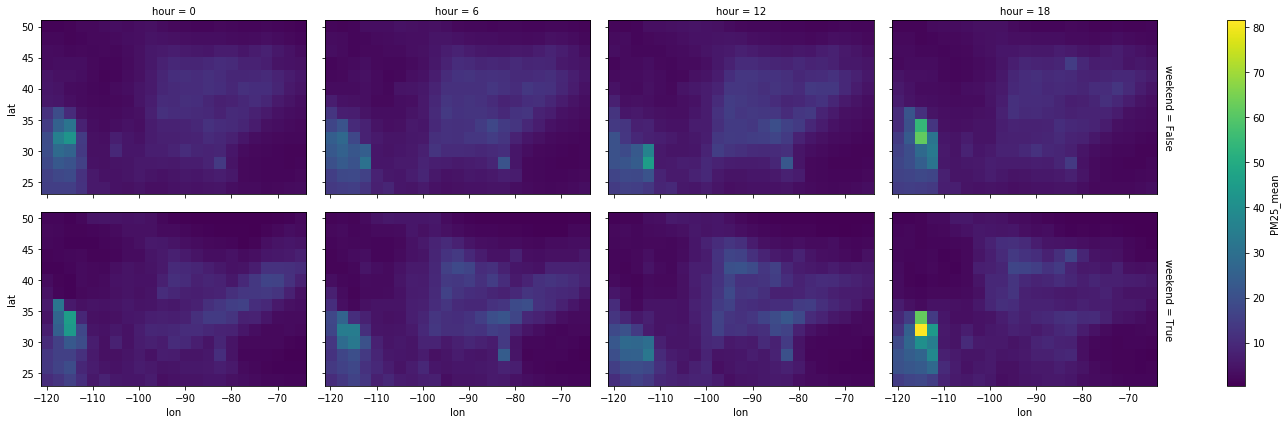

In [23]:
(weekend_day_hourly_pm25
    ['PM25_mean']
    .sel(hour=[0,6,12,18])
    .plot.imshow(
        x='lon', y='lat', row='weekend', col='hour', 
        aspect=16./10.
    )
)

Are there actually differences at these times of day?

/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:352: RuntimeWarning: invalid value encountered in greater
  x_extent) > FRACTIONAL_OFFSET_THRESHOLD
/Users/daniel/anaconda/lib/python3.5/site-packages/cartopy/img_transform.py:364: RuntimeWarning: invalid value encountered in greater
  y_extent) > FRACTIONAL_OFFSET_THRESHOLD


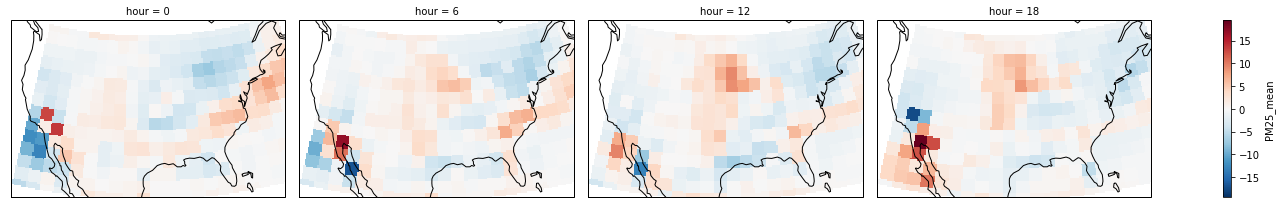

In [24]:
_pm25 = weekend_day_hourly_pm25['PM25_mean'].sel(hour=[0,6,12,18])
diffs = _pm25.sel(weekend=True) - _pm25.sel(weekend=False)

# Projection to better visualize USA
USA_PROJ = ccrs.AlbersEqualArea(central_longitude=-97., central_latitude=38.)

g = diffs.plot.imshow(x='lon', y='lat', col='hour', aspect=16./10.,
                      subplot_kws=dict(projection=USA_PROJ),
                      transform=ccrs.PlateCarree())
for ax in g.axes.ravel():
    ax.coastlines()
    ax.set_extent([-121, -72, 22.5, 50])

The answer seems to be a cursory "yes"; there seems to be higher PM25 during weekdays in the central USA, but lower over the northeast. There's also an interesting dipole between the land/ocean off the Atlantic coast in the early morning.

#### Difference in diurnal cycle

What if we combine these two ideas: how different is the diurnal cycle between weekends/weekdays? This is a bit more complicated to assess, but one approach we could use is to extend our previous calculations by first computing anomalies from the *daily average*. This would help control for systematic differences we seem to see from the previous plots.

We can explicitly code this calculation, breaking it down into steps:

In [25]:
proc_df = (
    df
    # Re-shape the data and derive fields for grouping
    .reset_index()
    .assign(hour=lambda x: x.time.dt.hour,
            day=lambda x: x.time.dt.dayofyear,
            weekend=lambda x: x.time.dt.weekday_name.isin(['Saturday',' Sunday']))
)

proc_df['PM25_daily_anom'] = (
    proc_df
    .groupby(['day', 'lon', 'lat'])
    ['PM25']
    .transform(_anom_from_mean)
)

hourly_anom_from_diurnal = (
    proc_df
    # Aggregate by hour across all days
    .groupby(['hour', 'weekend', 'lon', 'lat'])
    .agg({'mean', 'std'})
    ['PM25_daily_anom']
    .add_prefix("PM25_")
    .to_xarray()
)

With our processed dataset, we can now plot the diurnal cycles in anomalies directly

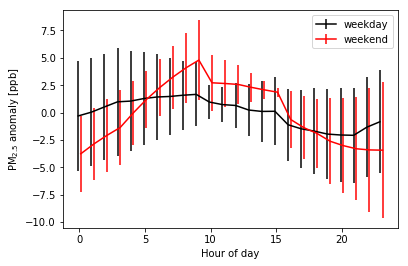

In [26]:
local = hourly_anom_from_diurnal.sel(lon=-85,lat=40)

weekday = local.sel(weekend=0)
weekend = local.sel(weekend=1)

plt.errorbar(weekday.hour.values-0.1, 
             weekday.PM25_mean.values, yerr=weekday.PM25_std.values,
             color='k', label='weekday')
plt.errorbar(weekend.hour.values+0.1, 
             weekend.PM25_mean.values, yerr=weekend.PM25_std.values,
             color='r', label='weekend')
plt.xlabel("Hour of day")
plt.ylabel("PM$_{2.5}$ anomaly [ppb]")
plt.legend()

So potentially over the weekends, there is lower $\mathrm{PM}_{2.5}$ at night than at day, and this cycle is more dramatic (for the location we chose). We still have large errorbars, so it's hard to say whether or not the values are different at any given hour.

For one final note, let's revisit this calculation but instead of computing the statistics for ourselves, let's let the [seaborn](http://seaborn.pydata.org) library take care of that for us.

To begin, we return to our master `DataFrame` which contains our derived result, prior to aggregate by day/hour. We'll then use one form of pandas' machinery to select the lon/lat coordinate we've been studying:

1. Reset the index to longitudes and latitudes
2. Select from the index by value

In [27]:
local = proc_df.set_index(['lon', 'lat']).loc[(-85, 40)].reset_index().copy()
local['weekend'] = local['weekend'].astype('category')

/Users/daniel/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


Using seaborn, the previous analysis/plotting can be done in just a single line, in a "grammar of graphics" style:

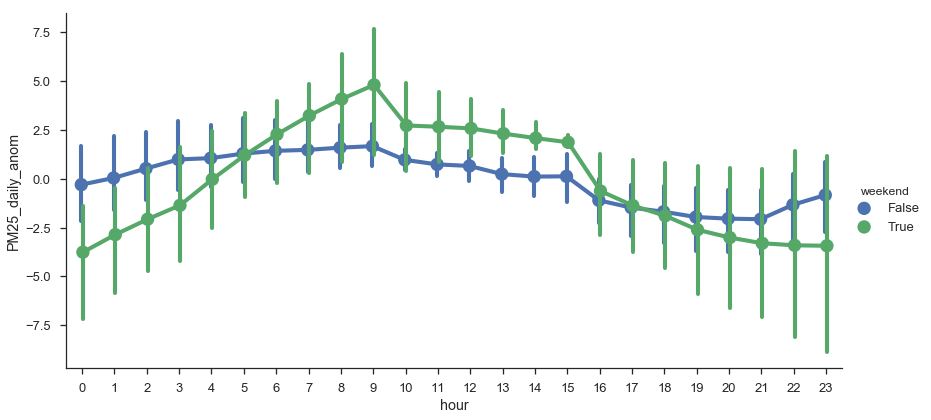

In [28]:
import seaborn as sns
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

sns.factorplot(data=local, x='hour', y='PM25_daily_anom',
               hue='weekend', dodge=True, size=6, aspect=2)

We can also do slightly more sophisticated analyis. For instance, we can visualize the joint and marginal distribution of the $\mathrm{PM}_{2.5}$ anomalies conditioned on whether it's the weekend or not with violin plots on the same general plot setup:

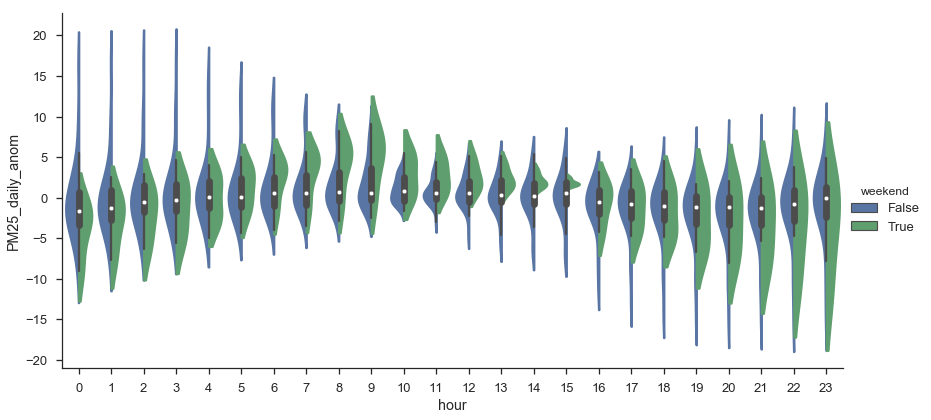

In [29]:
sns.factorplot(data=local, x='hour', y='PM25_daily_anom',
               hue='weekend', kind='violin', split=True,
               cut=1.5, scale='width',
               size=6, aspect=2)

Plotting each diurnal cycle trace shows more clearly what's going:

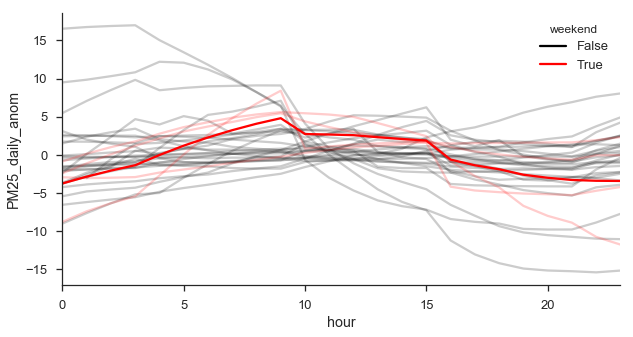

In [30]:
size, aspect = 5., 2.
width, height = size*aspect, size
fig = plt.figure(figsize=(width, height))
ax = fig.add_subplot(111)

ax = sns.tsplot(local, time='hour', value='PM25_daily_anom',
                unit='day', condition='weekend',
                err_style='unit_traces', color=['k', 'r'], ax=ax)
sns.despine()

In a nutshell, we have 3 times as many samples for weekdays as we do weekends, and these include 3 very large outliers. This is muddying the statistics, which is why we can't cleanly detect a difference between the two sets of days.

Keep in mind that seaborn - like xarray - s really just implementing some wrapper functions around other libraries (in this case, both pandas and matplotlib). It's taking care of the aggregation and plotting of your grouped data, as long as you take care to format the data into the ["tidy" data format](http://vita.had.co.nz/papers/tidy-data.html) that it expects. With a bit of tweaking to the keyword arguments you provide it, you can have seaborn create publication-quality plots very easily. Or, you can always create the plots by hand.

## Review

In this example, we used xarray and its core functions:

1. data sub-selection
2. vectorized calculations
3. plotting
4. catrographic plotting
5. two-way coordination with pandas
6. "split-apply-combine" workflows

Using this analysis, we investigated 3-weeks of hourly $\mathrm{PM}_{2.5}$ to study the differences in the diurnal cycle between weekdays and the weekend at a location in the United States. Although we couldn't statistically tease out a difference, we produced some data suggesting that this was due to a few outlier days during the set of weekdays in our study.

## Software Versions

In [31]:
import sys
import cartopy
import matplotlib
import numpy
import pandas
import seaborn
import xarray

print("Python: ", sys.version)
print("--"*40)
print("cartopy: ", cartopy.__version__)
print("matplotlib: ", matplotlib.__version__)
print("numpy: ", numpy.__version__)
print("pandas: ", pandas.__version__)
print("seaborn: ", seaborn.__version__)
print("xarray: ", xarray.__version__)

Python:  3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
--------------------------------------------------------------------------------
cartopy:  0.14.3
matplotlib:  2.0.0
numpy:  1.12.1
pandas:  0.20.1
seaborn:  0.7.1
xarray:  0.9.3
